## Time Series analysis of Covid-19 data obtained from a variety of sources

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy import signal
from my_kalman_filter1 import KalmanFilter
import plotly
from PIL import Image
import scipy
from statsmodels.tsa.stattools import acovf

Load in the dataset and interpolate the missing datetime entries

In [2]:
import plotly.express as px
def compare_countries(df, comparison=None, k=3):
    """
    Args:
        df (pandas df): the dataframe with covid data
        countries (list or string): a way to say which countries to compare or a single country to look at
    Returns:
        None
    """
    countries = df["Country"].unique()
    country_count = countries.shape[0]
    
    if not comparison:
        mask = np.arange(country_count)
        np.random.shuffle(mask)
        mask = mask[:k]
        
    else:
        mask = [np.where(country==df["Country"].unique())[0][0] for country in comparison]

    sub_df = df.query(f"Country in {list(countries[mask])}")
    fig = px.line(sub_df, x="Date_reported", y="New_cases", color='Country', title='Cumulative Cases')
    fig.show()

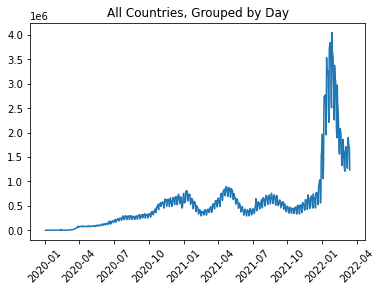

In [3]:
#Visualize the WHO data on new cases reported daily

who_df = pd.read_csv("WHO-COVID-19-global-data.csv")
who_df["Date_reported"] = pd.to_datetime(who_df["Date_reported"]) #make the dates a datetime object
org = who_df.groupby(["Date_reported"])["New_cases"].sum()        #Sum the new cases reported by date
org = pd.DataFrame(org, columns=["New_cases"])
plt.plot(org)
plt.xticks(rotation=45)
plt.title("All Countries, Grouped by Day")
plt.show()

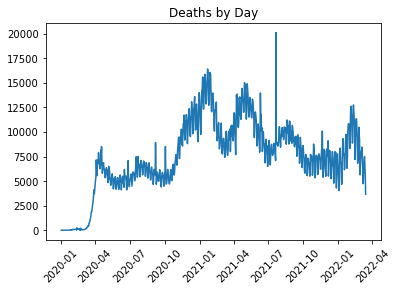

In [4]:
#Aggregate deaths by day for the world covid data

death_df = who_df.groupby(["Date_reported"])["New_deaths"].sum()
plt.plot(death_df)
plt.title("Deaths by Day")
plt.xticks(rotation=45)
plt.show()

C:\Users\calle\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


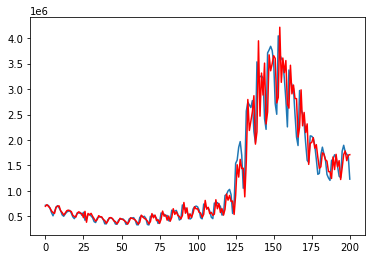

In [5]:
cases = np.array(org)

#Create predictions for new cases using a 75/25 split and an ARIMA model
#this was a rough first try

def predict_with_real(cases):
    train_cases, test_cases = cases[:int(len(cases)*.75)], cases[int(len(cases)*.75):]
    history = [x for x in train_cases]
    predict = []

    for t in range(len(test_cases)):
        model = ARIMA(history, order=(5,0,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predict.append(yhat)
        obs = test_cases[t]
        history.append(obs)

    plt.plot(test_cases)
    plt.plot(predict, color="red")
    plt.show()
    
    return predict
predict = predict_with_real(cases)

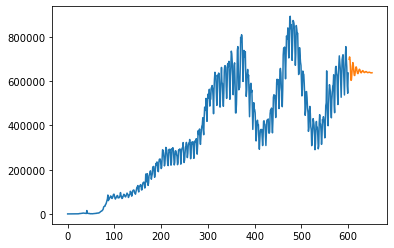

In [6]:
#Use ARIMA to predict into the future

def predict_with_predictions(cases):
    cases = cases.reshape(len(cases))
    train_cases, test_cases = cases[:int(len(cases)*.75)], cases[int(len(cases)*.75):]
    history = [x for x in train_cases]
    
    predict = []
    
    for t in range(50):
        model = ARIMA(history, order=(5,0,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predict.append(yhat)
        history.append(yhat)
        
    plt.plot(train_cases, label="Actual")
    plt.plot(np.arange(len(train_cases)+1, len(train_cases) + 51), predict, label="Predicted")
    plt.show()
    
    return predict, train_cases, test_cases
p, tr, te = predict_with_predictions(cases)

Text(0.5, 1.0, 'Case Count Predictions')

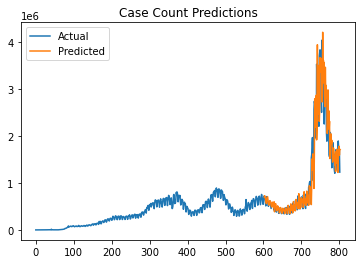

In [7]:
plt.plot(cases, label="Actual")
plt.plot(np.arange(int(len(cases)*.75) + 1, len(cases)+1), predict, label="Predicted")
plt.legend()
plt.title("Case Count Predictions")

In [8]:
#Using the USA dataframe of deaths, cases and hospitalizations in America
#combine with the WHO data for the US

who_df = pd.read_csv("WHO-COVID-19-global-data.csv")
who_df["Date_reported"] = pd.to_datetime(who_df["Date_reported"])
hospital = pd.read_csv("daily.csv")
hospital["dateChecked"] = [date[:10] for date in list(hospital["dateChecked"])]
hospital["dateChecked"] = pd.to_datetime(hospital["dateChecked"])
usa = who_df[who_df["Country"] == "United States of America"]
usa = usa.groupby(["Date_reported"])[["New_cases", "New_deaths", "Cumulative_cases"]].sum()
usa = pd.DataFrame(usa, columns=["New_cases", "New_deaths", "Cumulative_cases"])

In [9]:
hospital.index = hospital["dateChecked"]

In [10]:
#Combine hospitalization data with the US Covid data
hosp_comb = hospital.join(usa)
hosp_comb.index = hosp_comb["dateChecked"]

In [11]:
vax = pd.read_csv("Vaccine_Status.csv")

In [12]:
vax["Date"] = pd.to_datetime(vax["Date"])
vax_total = vax.groupby(["Date"])["Series_Complete_Yes"].sum()

In [13]:
vax_total = pd.DataFrame(vax_total, columns=["Series_Complete_Yes"])

<AxesSubplot:xlabel='dateChecked'>

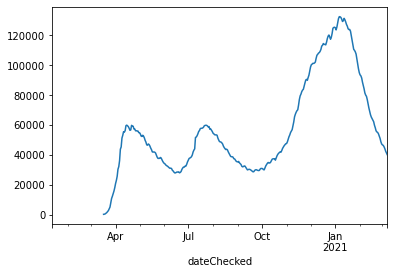

In [14]:
hospital["hospitalizedCurrently"].plot()

<AxesSubplot:xlabel='dateChecked'>

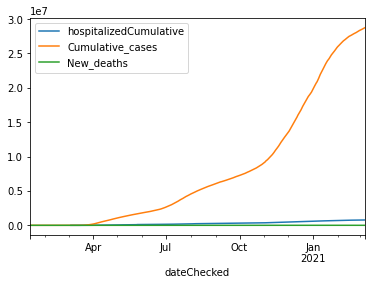

In [15]:
#hosp_comb[["hospitalizedCurrently", "New_cases", "New_deaths"]].plot()
hosp_comb[["hospitalizedCumulative", "Cumulative_cases", "New_deaths"]].plot()


In [17]:
with_vax = vax_total.join(hosp_comb)

<AxesSubplot:xlabel='Date'>

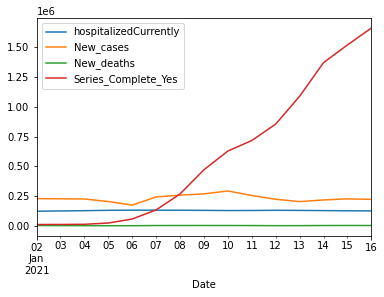

In [18]:
#Vaccination data combined the the US and hospital data
#The graph shows how many people have received both vaccination doses compared to 
#new cases, deaths, and hospitalizations

with_vax[["hospitalizedCurrently", "New_cases", "New_deaths", "Series_Complete_Yes"]][20:35].plot()

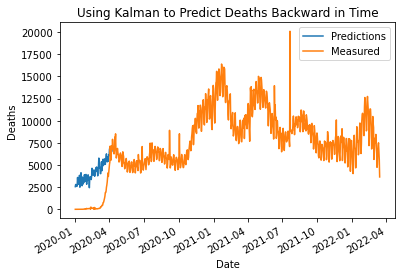

In [19]:
#Define a new KalmanFilter object in order to better identify the true number of deaths attributable to Covid
#Make predictions of deaths before Covid reporting became a thing

kf = KalmanFilter(1.01,900,1.08,300,0,one_d=True)
true = death_df.values.copy()
deaths = death_df.values.copy()
init = deaths[100]
preds = kf.rewind(init, 100) + np.random.normal(0, 400, size=100)
deaths[:100] = preds[::-1]
#plt.plot(np.arange(1,101)[::-1], preds)

plt.plot(death_df.index[:100], deaths[:100], label="Predictions")
death_df.plot(label="Measured")
plt.title("Using Kalman to Predict Deaths Backward in Time")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.legend()

#plt.savefig("predict_deaths.png", dpi=300)

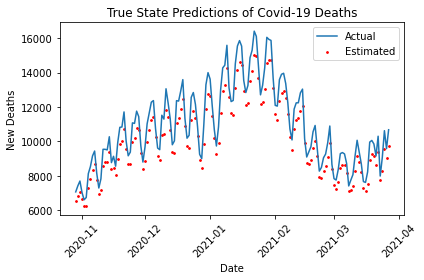

In [20]:
#Make kalman filter estimates on a certain slice of the already existing data

obs_slice = true[300:450]
x0 = obs_slice[0]
P0 = 100000
x_final, P_final = kf.estimate(x0, P0, obs_slice)
#the_fig = plt.figure(figsize=(4,2))
plt.plot(death_df.index[300:450], true[300:450], label="Actual")
plt.scatter(death_df.index[300:450], x_final, color="red", s=3, label="Estimated")
plt.xticks(rotation=45)
plt.title("True State Predictions of Covid-19 Deaths")
plt.xlabel("Date")
plt.ylabel("New Deaths")
plt.legend()
plt.tight_layout()
plt.savefig("state_death1.png", dpi=300)

In [21]:
#Use a 5 week stagger between infection and deaths to measure the effects of the offset between
#infection an death

x_deaths = np.array(usa["New_deaths"][275:375])
rate = []
for j in range(len(x_deaths)-1):
    rate.append((x_deaths[j+1] - x_deaths[j])/x_deaths[j])
pred_rate = np.mean(rate)


kf_cases = KalmanFilter(1+pred_rate,800,1/.02,600,0,one_d=True)

true_cases = np.array(usa["New_cases"])[240:340]


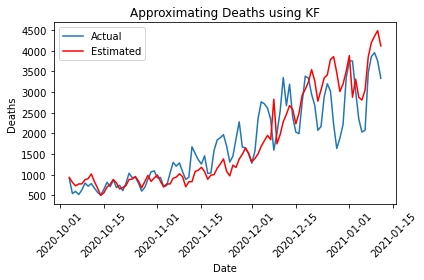

In [22]:
#Using the 5 week stagger, plot the expected deaths on top of current cases

obs_slice_death = true_cases
x0 = obs_slice_death[0]
P0 = 100000
x_final_case, P_final_case = kf_cases.estimate(x0, P0, obs_slice_death)
#the_fig = plt.figure(figsize=(4,2))


plt.plot(usa.index[275:375], x_deaths, label="Actual")

plt.plot(usa.index[275:375], x_final_case, color="red", label="Estimated")
plt.legend()
plt.xticks(rotation=45)
plt.title("Approximating Deaths using KF")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.tight_layout()
plt.savefig("approx_death.png", dpi=300)